In [1]:
from utils.result import *
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from scipy.io import loadmat
from utils.get_data import *
from utils.other_methods import *
%reload_ext autoreload
%autoreload 2
stimuli = ['0-BEA', '0-BOL', '0-Ctl', '1-DatExt', '0-FAR', '0-GER', '0-ISO', '0-LIN', 
           '0-M2', '0-M3', '0-M4', '0-M5', '0-M6', '0-MAL', '0-MYR', '0-NER', 
           '1-P3', '1-P4', '1-P5', '1-P9', '1-P9_Hund', '1-P9_Ten', '1-P9_TenThous']		

mixture_dict = {"1-P9":["0-BEA","0-BOL","0-MAL","0-MYR","0-LIN","0-NER","0-GER","0-ISO","0-FAR"],
                "1-P5":["0-BEA","0-BOL","0-LIN","0-NER","0-GER"],
                "1-P4":["0-BEA","0-BOL","0-LIN","0-NER"],
                "1-P3":["0-BEA","0-BOL","0-LIN"],
                "0-M6":["0-MAL","0-MYR","0-NER","0-GER","0-ISO","0-FAR"],
                "0-M5":["0-MAL","0-MYR","0-GER","0-ISO","0-FAR"],
                "0-M4":["0-MAL","0-MYR","0-ISO","0-FAR"],
                "0-M3":["0-MAL","0-ISO","0-FAR"],
                "0-M2":["0-BEA","0-BOL"]}

time_resolution=3
components =["0-BEA","0-BOL","0-MAL","0-MYR","0-LIN","0-NER","0-GER","0-ISO","0-FAR", "0-DATEXT", "0-CTL"]


In [4]:
import glob
df_all = None
neurons_all = None
for csv in glob.glob("/hpc/group/tarokhlab/hy190/data/AL/ALdata/*"):
    if ".csv" in csv and "timestamp" not in csv:
        print(csv)
        path=csv
        time_resolution=3
        df, neurons = read_moth(path, time_resolution)
        neurons_csv = [csv + n for n in neurons]
        name_mapper = {neurons[i]: neurons_csv[i] for i in range(len(neurons))}
        df = df.rename(columns=name_mapper)
        if "P9_THOUS" in set(df['stimuli'].str.upper().to_list()):
            print(csv)
            continue
        df[["label", "stimuli"]].drop_duplicates()
        df["label_stim"] = df["label"].astype(str) + "-" + df["stimuli"].str.upper()
        if df_all is not None:
            df_all = pd.concat([df_all, df], axis=1)
            neurons_all += neurons_csv
        else:
            df_all = df
            neurons_all = neurons_csv
        all_stimuli_count = df.value_counts("label_stim").to_dict()
        all_stimuli_count = dict(sorted(all_stimuli_count.items()))
        num_stimuli =  len(all_stimuli_count)
        
df = df_all.copy()
df = df.loc[:,~df.columns.duplicated()].copy()

            

/hpc/group/tarokhlab/hy190/data/AL/ALdata/070924_1_cleaned.csv
/hpc/group/tarokhlab/hy190/data/AL/ALdata/070921_cleaned.csv
/hpc/group/tarokhlab/hy190/data/AL/ALdata/070922_cleaned.csv
/hpc/group/tarokhlab/hy190/data/AL/ALdata/070906_cleaned.csv
/hpc/group/tarokhlab/hy190/data/AL/ALdata/070913_cleaned.csv
/hpc/group/tarokhlab/hy190/data/AL/ALdata/070924_2_cleaned.csv
/hpc/group/tarokhlab/hy190/data/AL/ALdata/071002_cleaned.csv
/hpc/group/tarokhlab/hy190/data/AL/ALdata/071002_cleaned.csv


In [5]:

taus = np.array(list(range(2,11)))/1000
all_tau_list = []
for tau in taus:
    sim_result = {}
    dur_stim = []
    all_stim_sync_index = []
    triu_index = np.triu_indices(14,1)
    for s_index, s in enumerate(all_stimuli_count):
        # One hot encoding with components
        sim_result[s] = []
        for run in range(all_stimuli_count[s]):
            data_concat_has_spike, neurons_has_spike = make_spiketrain(df, 
                                                                    s,
                                                                    run,
                                                                    neurons_all, 
                                                                    time_resolution, 
                                                                    0,
                                                                    False)
            
            data_concat_smooth = exponential_smoothing_spike(data_concat_has_spike,time_resolution,tau=tau)
            sim_mat = similarity_measure(data_concat_smooth[400:800])
            sim_mat_shuffle = []
            for run_shuffle in range(all_stimuli_count[s]):
                if run == run_shuffle: continue
                data_shuffle, neurons_has_spike = make_spiketrain(df, 
                                                                s,
                                                                run_shuffle,
                                                                neurons_all, 
                                                                time_resolution, 
                                                                0,
                                                                False)
                data_shuffle_smooth = exponential_smoothing_spike(data_shuffle,time_resolution,tau=tau)
                sim_mat_shuffle.append(similarity_measure_shuffle(data_concat_smooth[400:800], 
                                                                data_shuffle_smooth[400:800]))
            mean_shuffle = np.mean(sim_mat_shuffle,0)
            after_shuffle = sim_mat - mean_shuffle
            sim_result[s].append(after_shuffle)
        all_stim_sync_index.append(np.mean(sim_result[s],0)[triu_index].flatten())
    all_tau_list.append((sim_result,all_stim_sync_index))

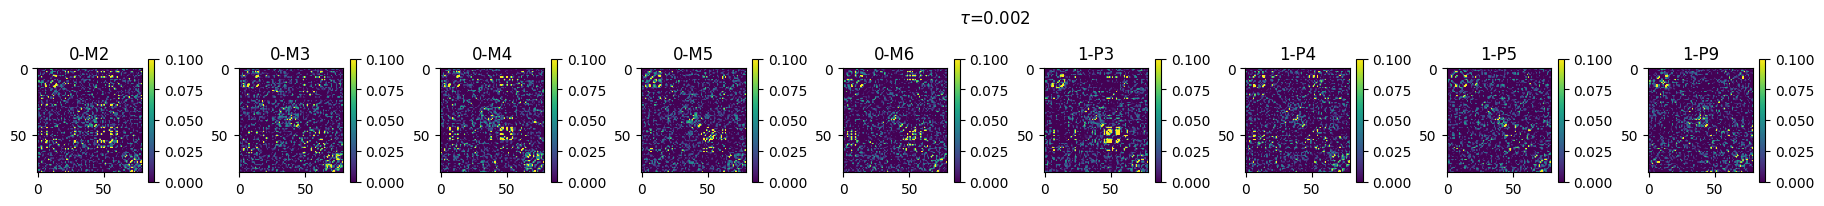

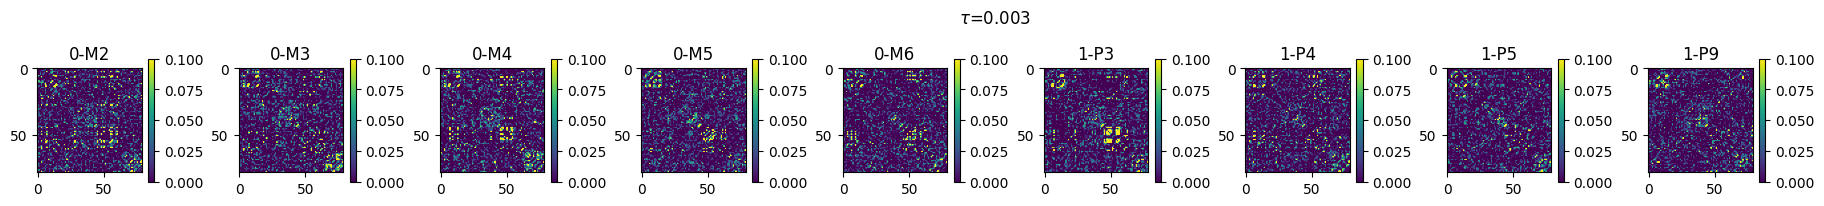

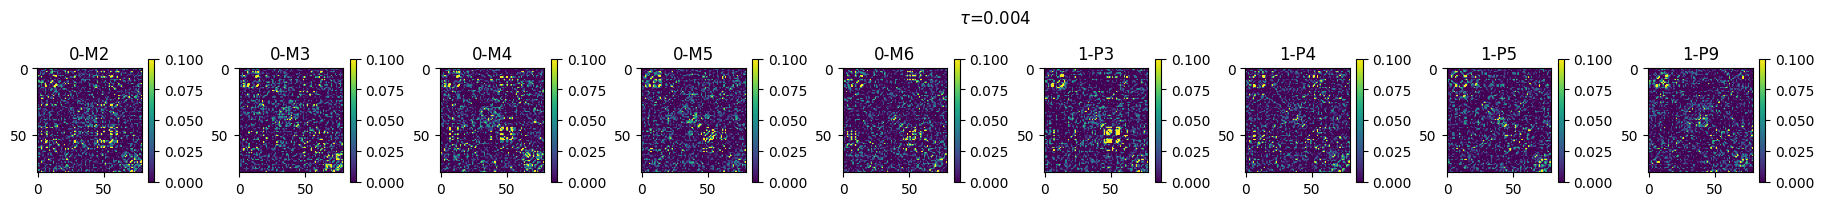

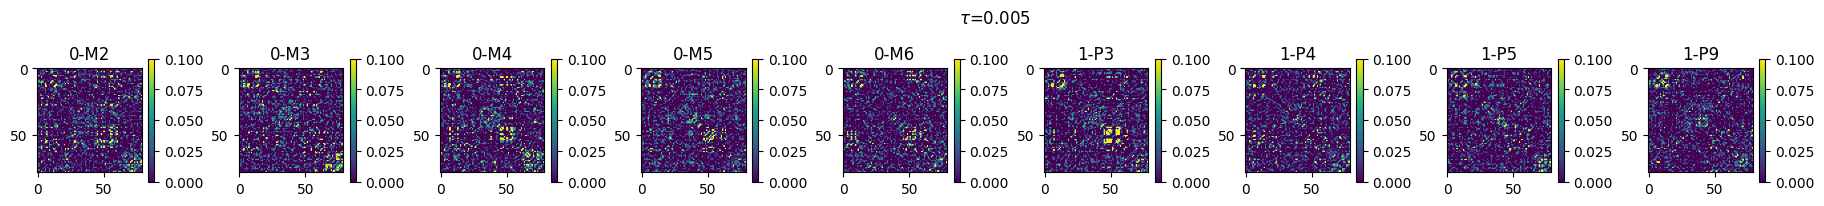

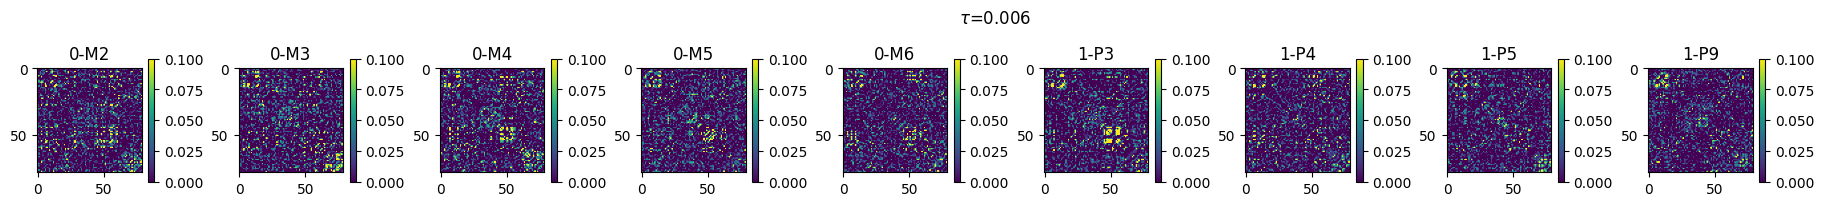

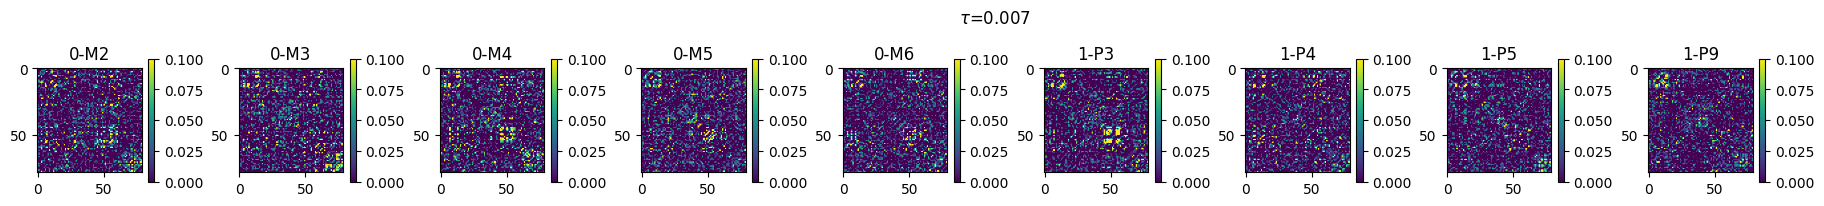

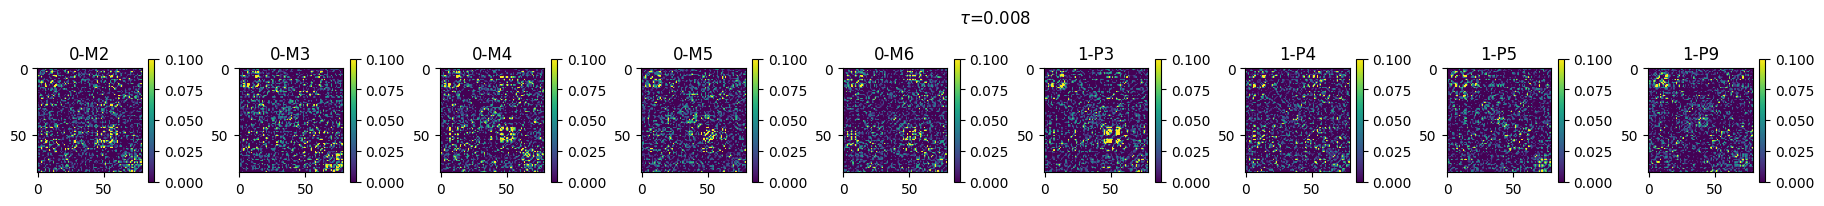

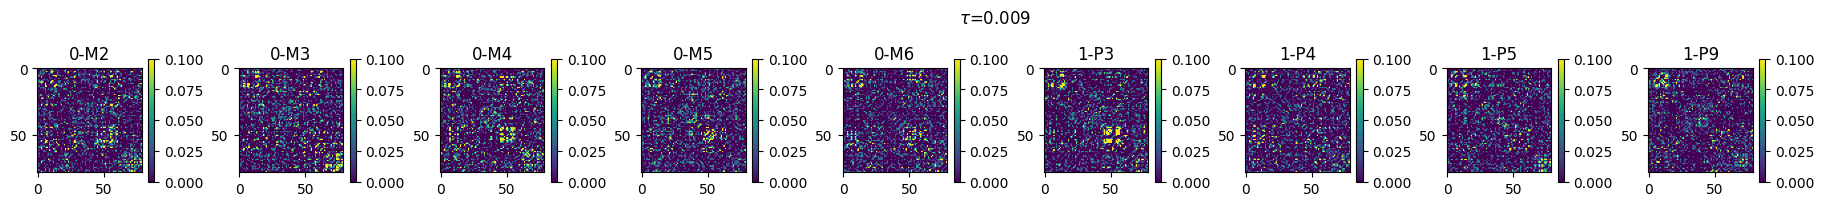

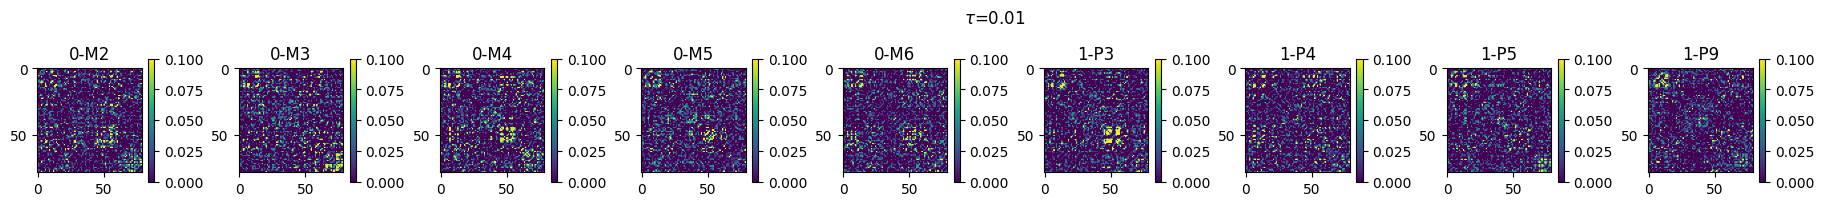

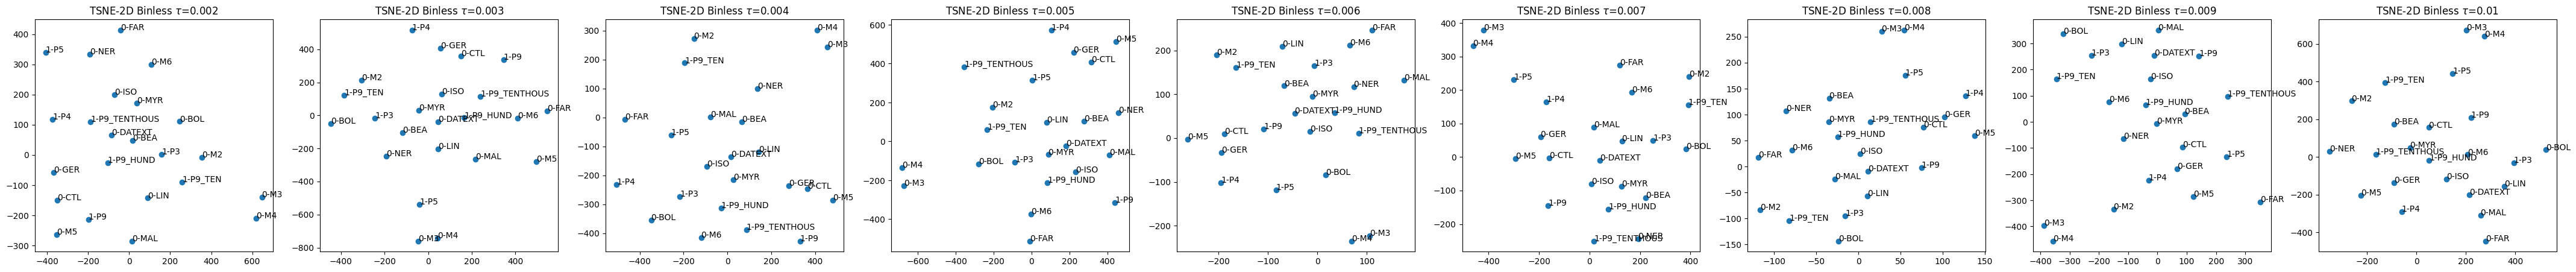

In [ ]:
stim_int = ["1-DatExt",	"1-P9",	"1-P5",	"1-P4",	"1-P3",
            "0-M6",	"0-M5",	"0-M4",	"0-M3",	"0-M2"]
for i, tau in enumerate(taus):
    triu_index = np.triu_indices(14,1)
    count = 1
    plt.figure(figsize=(20,2))
    sim_result = all_tau_list[i][0]
    for i,stim in enumerate(sim_result):
        if stim in stim_int:
            empty_mat=np.mean(sim_result[stim],0)#
            full_mat = empty_mat + empty_mat.T
            plt.subplot(1,10,count)
            plt.imshow(full_mat, vmin=0, vmax=0.1)
            plt.title(stim)
            plt.colorbar()
            count += 1
    plt.suptitle(r'$\tau$={}'.format(tau))
    plt.tight_layout()
    
fig, axes = plt.subplots(figsize=(6*len(taus),5), ncols=len(taus))
count = 0
for i, tau in enumerate(taus):
    all_stim_sync_index = np.array(all_tau_list[i][1])
    tsne = TSNE(n_components=2, perplexity=5)
    a = tsne.fit_transform(all_stim_sync_index)
    axes[count].scatter(a[:,0], a[:,1])
    for j in range(0, len(a)):
        axes[count].annotate(list(sim_result.keys())[j], (a[j,0], a[j,1]))
    axes[count].set_title("TSNE-2D Binless " + r'$\tau$={}'.format(tau))
    count += 1
plt.savefig("2dTSNE_binless_stack.pdf", bbox_inches="tight")

/hpc/group/tarokhlab/hy190/data/AL/ALdata/070924_1_cleaned.csv
/hpc/group/tarokhlab/hy190/data/AL/ALdata/070921_cleaned.csv
/hpc/group/tarokhlab/hy190/data/AL/ALdata/070922_cleaned.csv
/hpc/group/tarokhlab/hy190/data/AL/ALdata/070906_cleaned.csv
/hpc/group/tarokhlab/hy190/data/AL/ALdata/070913_cleaned.csv
/hpc/group/tarokhlab/hy190/data/AL/ALdata/070924_2_cleaned.csv
/hpc/group/tarokhlab/hy190/data/AL/ALdata/071002_cleaned.csv


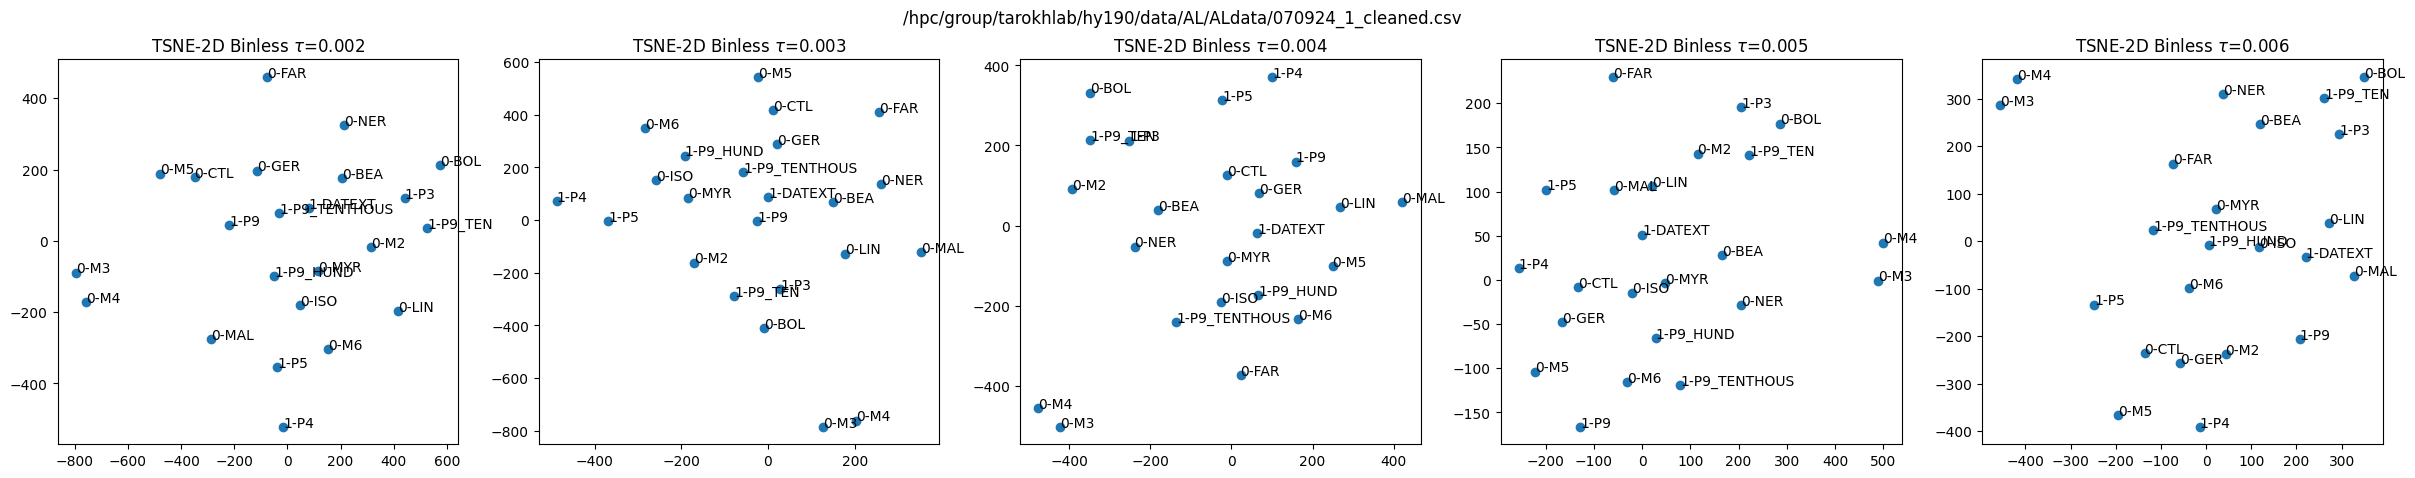

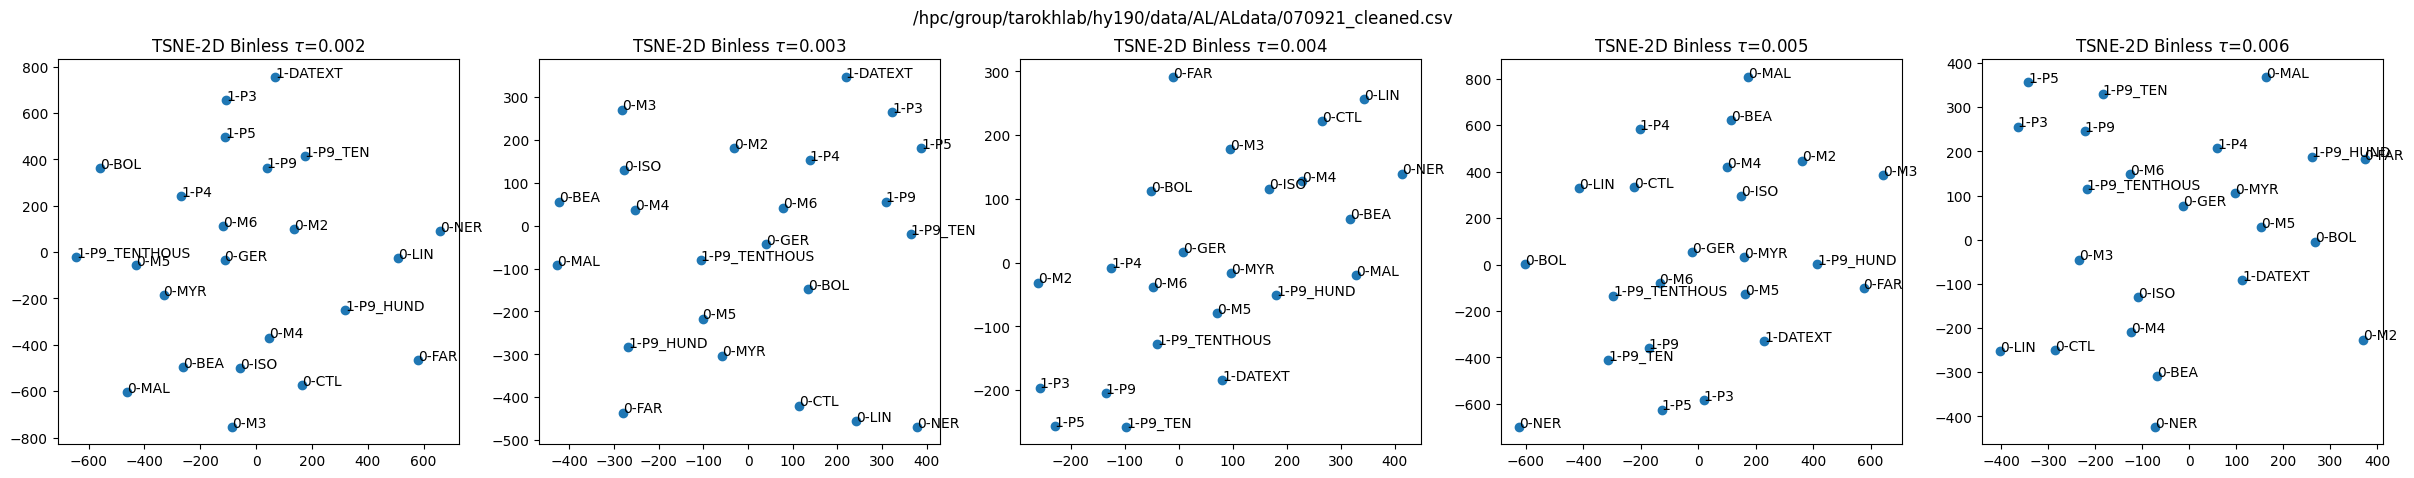

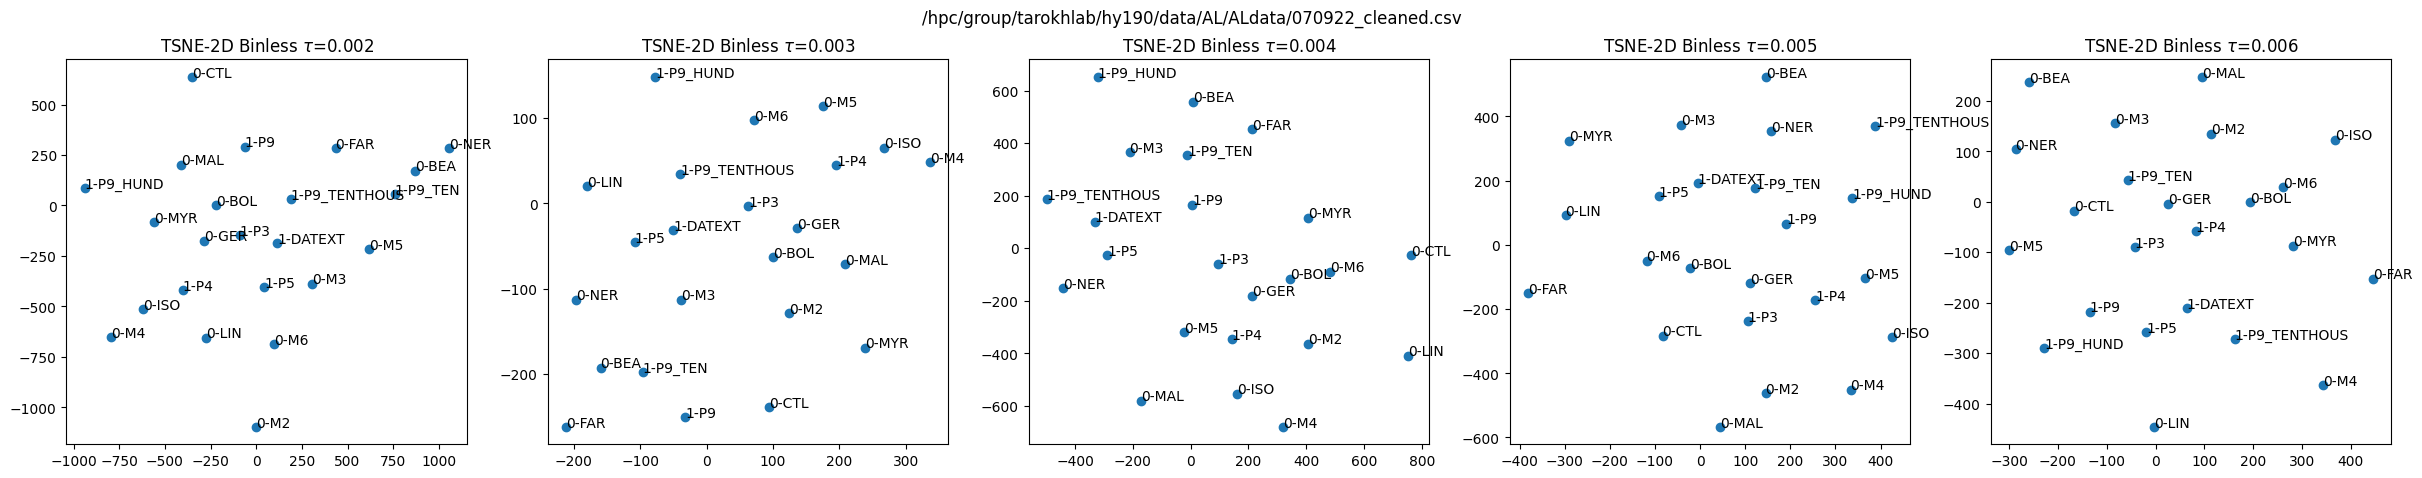

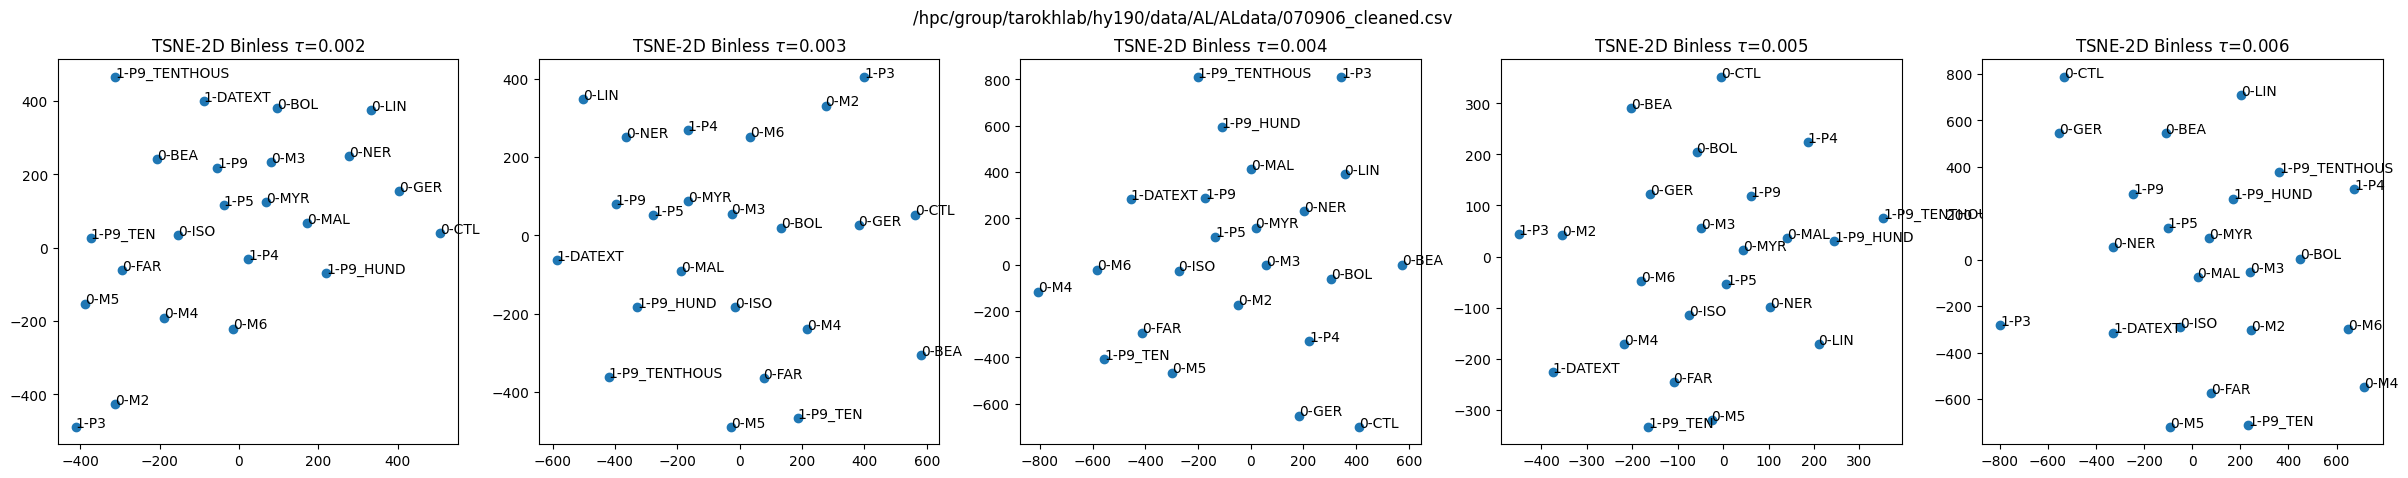

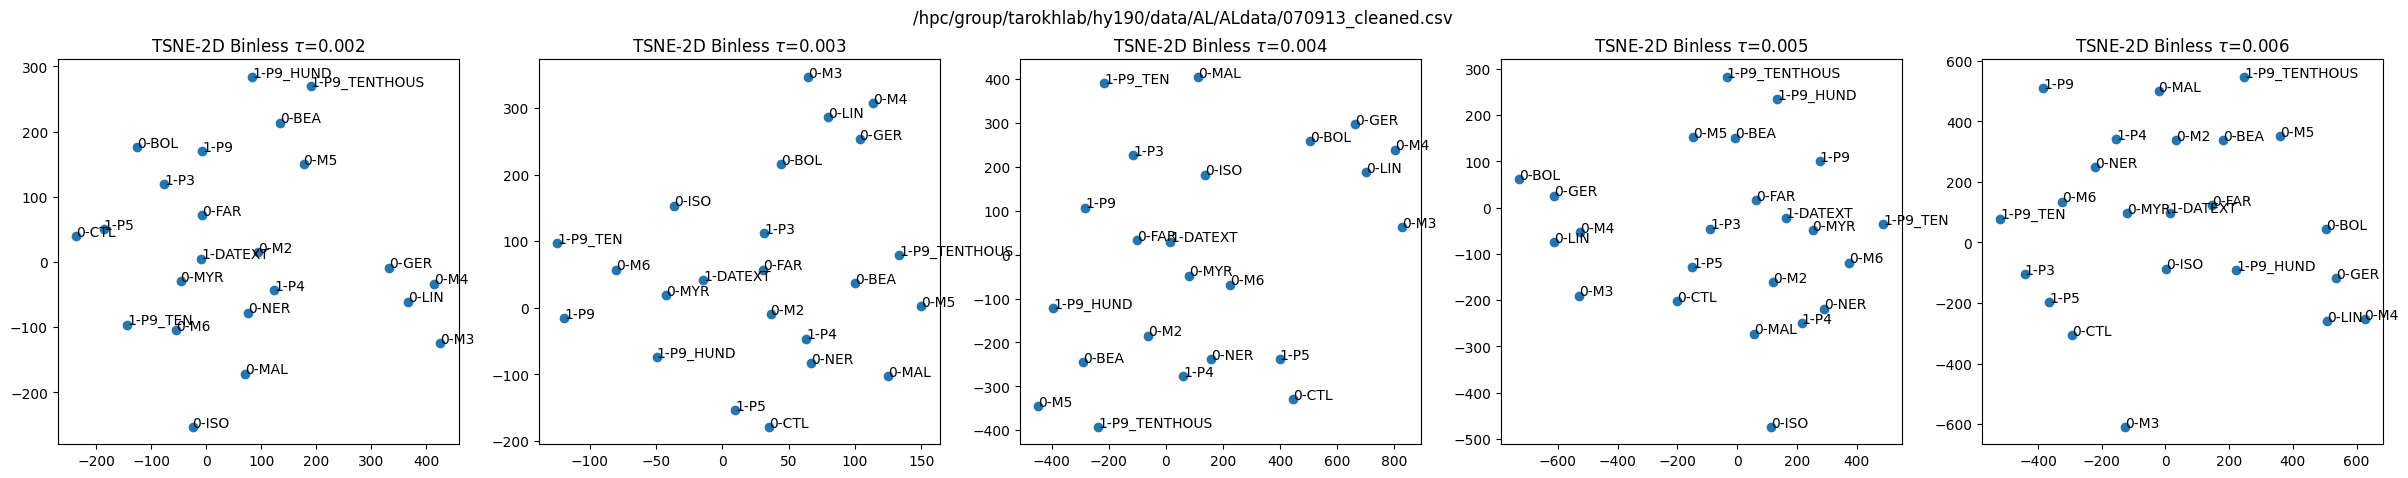

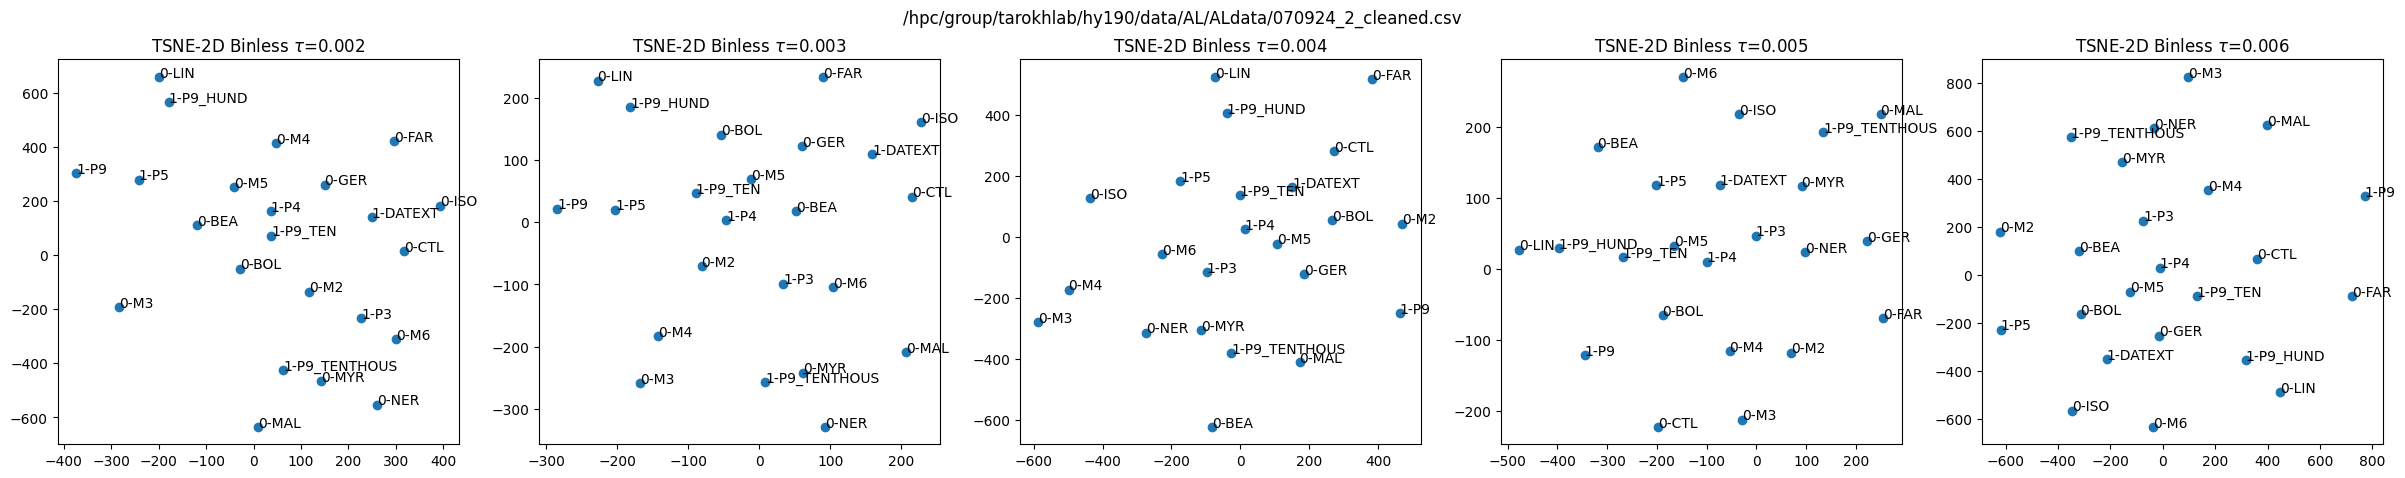

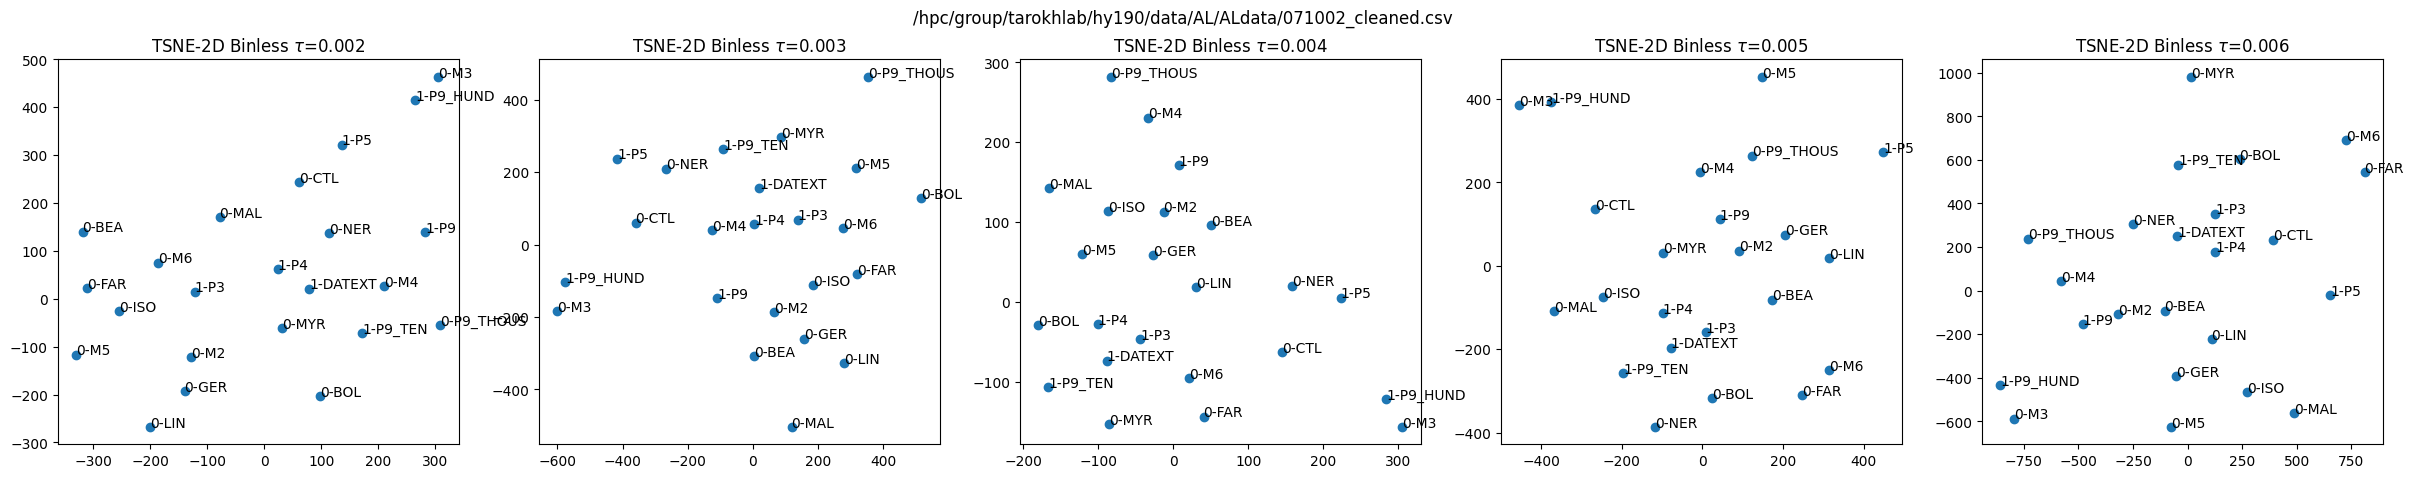

In [8]:
import glob
df_all = None
neurons_all = None
for csv in glob.glob("/hpc/group/tarokhlab/hy190/data/AL/ALdata/*"):
    if ".csv" in csv and "timestamp" not in csv and "pre_stim" not in csv:
        print(csv)
        path=csv
        time_resolution=3
        df, neurons = read_moth(path, time_resolution)
        neurons_csv = [csv + n for n in neurons]
        name_mapper = {neurons[i]: neurons_csv[i] for i in range(len(neurons))}
        df = df.rename(columns=name_mapper)
        df[["label", "stimuli"]].drop_duplicates()
        df["label_stim"] = df["label"].astype(str) + "-" + df["stimuli"].str.upper()
        all_stimuli_count = df.value_counts("label_stim").to_dict()
        all_stimuli_count = dict(sorted(all_stimuli_count.items()))
        num_stimuli =  len(all_stimuli_count)
        
        taus = np.array(list(range(2,7)))/1000
        all_tau_list = []
        for tau in taus:
            sim_result = {}
            dur_stim = []
            all_stim_sync_index = []
            triu_index = np.triu_indices(len(neurons_csv),1)
            for s_index, s in enumerate(all_stimuli_count):
                # One hot encoding with components
                sim_result[s] = []
                for run in range(all_stimuli_count[s]):
                    data_concat_has_spike, neurons_has_spike = make_spiketrain(df, 
                                                                            s,
                                                                            run,
                                                                            neurons_csv, 
                                                                            time_resolution, 
                                                                            0,
                                                                            False)
                    
                    data_concat_smooth = exponential_smoothing_spike(data_concat_has_spike,time_resolution,tau=tau)
                    sim_mat = similarity_measure(data_concat_smooth[400:800])
                    sim_mat_shuffle = []
                    for run_shuffle in range(all_stimuli_count[s]):
                        if run == run_shuffle: continue
                        data_shuffle, neurons_has_spike = make_spiketrain(df, 
                                                                        s,
                                                                        run_shuffle,
                                                                        neurons_csv, 
                                                                        time_resolution, 
                                                                        0,
                                                                        False)
                        data_shuffle_smooth = exponential_smoothing_spike(data_shuffle,time_resolution,tau=tau)
                        sim_mat_shuffle.append(similarity_measure_shuffle(data_concat_smooth[400:800], 
                                                                        data_shuffle_smooth[400:800]))
                    mean_shuffle = np.mean(sim_mat_shuffle,0)
                    after_shuffle = sim_mat - mean_shuffle
                    sim_result[s].append(after_shuffle)
                all_stim_sync_index.append(np.mean(sim_result[s],0)[triu_index].flatten())
            all_tau_list.append((sim_result,all_stim_sync_index))
        fig, axes = plt.subplots(figsize=(6*len(taus),5), ncols=len(taus))
        count = 0
        for i, tau in enumerate(taus):
            all_stim_sync_index = np.array(all_tau_list[i][1])
            tsne = TSNE(n_components=2, perplexity=5)
            a = tsne.fit_transform(all_stim_sync_index)
            axes[count].scatter(a[:,0], a[:,1])
            for j in range(0, len(a)):
                axes[count].annotate(list(sim_result.keys())[j], (a[j,0], a[j,1]))
            axes[count].set_title("TSNE-2D Binless " + r'$\tau$={}'.format(tau))
            count += 1
        fig.suptitle(csv)